# Hill Climbing

This is a trajectory based local search technique but its metaheuristic is really simple, so we thought it would be more appropriate to add it here at first instead of the repository of trajectory based algorithms to give you a taste of what is coming.

---

The idea of the algorithm is simple; if you have a value of objective function that you want to optimize, you check the neighbours of that value and choose the neighbour that has more optimal value. If there is not such neighbour, terminate the search and return the current value.  

With that, you can get easily stuck at local optimal points, and flat areas in the objective function where there is no progress.

__HILL-CLIMBING__( _source_ , _destination_ ) __returns__ a route   
&emsp; _current_ &larr; random route from _source_ , _destination_  
&emsp; _neighbours_ &larr; children of _current_  
&emsp; __while__ min _neighbours_ &lt; _current_ __do__  
&emsp;&emsp; _current_ &larr; min _neighbours_   
&emsp;&emsp; _neighbours_ &larr; children of _current_  
&emsp; __return__ _current_

--- 
This is the first time to use the idea of generating children of a route and treating the route between two specific nodes as a function with a value which is the distance between these two nodes.  

Let's talk about that again (the first time is [here](https://github.com/SmartMobilityAlgorithms/GettingStarted/blob/master/utils.ipynb)), we needed a function defined to be optimized in the first place; a function over all the possible routes between two specific nodes that we are trying to find the shortest path between them. We could have generated random permutations between these two nodes and took the permutations that are actual and feasible routes between them and optimize our "function" over these random, sparse permutations. But with that we can't say we are stuck at local optimum value or that we reproduce the same output every run because these are just random permutations.  

What we did is that we have made a determinstic policy that generates number of routes between two nodes by successively failing nodes between source and destination and have a gap in the route which will be stitched with the shortest path between the node before the failure and the node after the failure. 

By failing the nodes in a determinstic fashion, we can say that we have a function and neighbourhood with defined size for a certain value so we can "rigorously" talk about local search.

In [10]:
import osmnx as ox
import time, math
from collections import deque
from tqdm import tqdm
from itertools import islice
from utilities import *

Here OSMnx find the largest connected component centered around the ```location point``` with specified ```dist``` on each side (w/n/e/s).

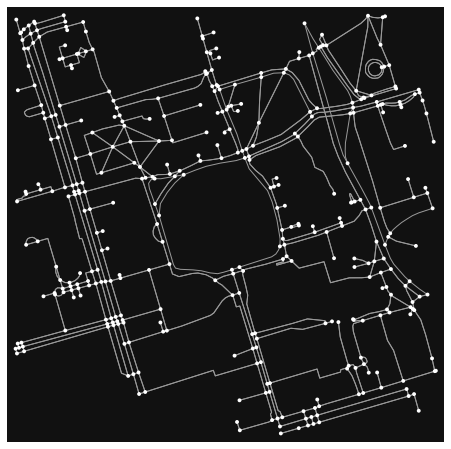

In [3]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

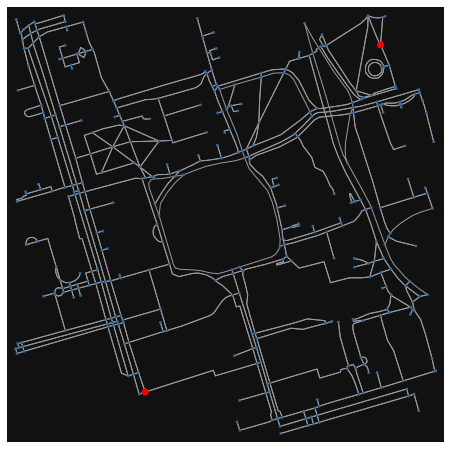

In [4]:
highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [5]:
draw_map(G, highlight = highlighted)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

Each node in our graph is represented as a dictionary with many attributes of no interest to us now, so manipulating them would obfuscate the algorithm jumping through hoops to get only one attribute from the dictionary. <b>so</b> we define class ```Node``` which only retains the data we need to be able to do searching and traversing, like the parent of the node (the one that produced it from its expansion) and the length of the edge between the parent and the node itself.

Please check its source code in ```./utilities/src/common.py``` to know how it captures the data from the graph. 

In [6]:
source(Node)

# The Algorithm

In [7]:
# first define the origin/source nodes as Node
origin = Node(graph = G, osmid = 55808290)
destination = Node(graph = G, osmid = 389677909)

In [37]:
%%time
# we will only take 20 child to make the algorithm running lightweight

current = randomized_search(G, origin.osmid, destination.osmid)
neighbours = [*islice(children_route(G, current), 25)] 
shortest = min(neighbours , key = lambda route : cost(G, route))

# sometimes the random generated route is what you got
# and no iterations happen at all

while cost(G, shortest) < cost(G, current):
    current = shortest
    neighbours = [*islice(children_route(G, current), 25)]
    shortest = min(neighbours , key = lambda route : cost(G, route))
    
    print(f"The cost of the path now is {cost(G, current)} and the best child is {cost(G, shortest)}")

The cost of the path now is 850.3480000000001 and the best child is 801.4639999999999
The cost of the path now is 801.4639999999999 and the best child is 801.9469999999999


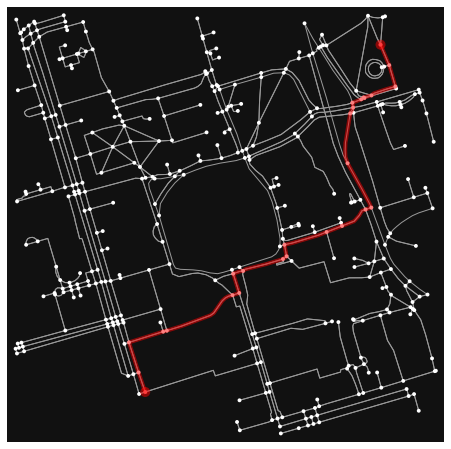

In [38]:
fig, ax = ox.plot_graph_route(G, current)

In [33]:
draw_route(G, current)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

You probably are going to get a good results because there is not many local optimal points in the route function, but imagine having much bigger search space with a lot of valley and hills, you will get stuck very fast.   

It is like climbing a mountain and you only can see 1 meter around you, so if you stand on a rock at the bottom of the moutain, it is the top of "your" mounatin.